# Graph Neural Networks with xbatcher



## Introduction

In this tutorial, we will explore how to solve one kind of graph neural network problem with xbatcher, networkx, and PyTorch. This tutorial closely mirrors the tutorial for using xbatcher with standard convolutional neural networks (CNN) (TODO: insert link). We are actually solving the same problem of learning surface currents from a few different quantities observable from satellites, just with a different approach. We chose to use graph convolutional neural networks (GNNs), because in the CNN-based model, we had to throw out a lot of data near coastlines and islands. This is not ideal because quite a lot of physics happens in these areas, particularly with western boundary currents and related phenomena. A GNN approach can avoid this issue because graphs can have an arbitrary shape independent of model grids.

Some key differences between a typical array-based analysis and a graph-based analysis:
- Graphs contain information about connectivity between nodes, rather than information about the position of each node like an array does. This means that when converting between an array and a graph, some care must be taken so that graphs can likewise be converted back to arrays. Distances between points are preserved when converting arrays to graphs, but the angles between edges are not.
- Graphs as a whole do not have a sense of orientation. We can expect that when plotting the same graph, we might get different results because the graph itself can be rotated, translated, mirrored, etc.

There are several distinct kinds of graph neural network problems, which can include
- Learning nodes on a single graph
- Learning graph shapes
- Learning fields on a graph from other fields on the same graph

The last type is the kind of problem we have here.

## Imports

Importing some common libraries here. We'll use the networkx package to facilitate graph construction and operations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import networkx as nx

from dataclasses import dataclass
from typing import Iterable
from itertools import product
from intake import open_catalog

Here we import the necessary pyTorch libraries. torch_geometric is something of a misnomer, it's the library for graph operations in pyTorch. torch_geometric offers some standardization of the API needed for using graphs in pyTorch, and offers some implementations used in research as well. We also want conversion functions for interoperability with networkx.

In [2]:
# Need a cruft check on these

import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Sequential as Seq, Linear, ReLU


from torch_geometric.utils.convert import to_networkx, from_networkx

And finally, import xbatcher...

In [3]:
import xbatcher as xb

## Setup

We can use a software design similar to the one we used for standard CNNs. Here we reuse the Scenario dataclass and the data import scheme.

In [4]:
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [5]:
target = ['U', 'V']

In [6]:
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

In [7]:
%run ./surface_currents_prep.ipynb

In [8]:
# prepare_data(sc5, 200, 1000, 1000, 200)

In [9]:
ds_training = load_training_data(sc5)
ds_training = just_the_data(ds_training)
ds_training = select_from(ds_training)
ds_training

<xarray.Dataset>
Dimensions:  (nlat: 550, nlon: 350)
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    SST      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUX     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUY     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    U        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    V        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    X        (nlat, nlon) float64 dask.array<chunksize=(550, 350), meta=np.ndarray>
    mask     (nlat, nlon) bool dask.array<chunksize=(100, 350), meta=np.ndarray>

## Testing setup for graph conversions

To be clear, we are starting with xarray data, and we want to convert it to a data type compatible with torch_geometric. We can probably convert it all manually, but the conversion functions between networkx and torch_geometric are appealing. networkx also has a few other functions that provide an added benefit. 

However, there is currently no official way to convert xarray data to networkx, so we'll have to do that manually.

So, how will we know if this conversion actually works? We can set up a couple of unit tests with data that represents a corner case, wherein the valid portions of the stencil are completely separated by lanes of invalid data. This situation could occur around places like Panama, southern Thailand, Italy, or some other isthmuses or islands. This could pose a problem for a graph neural network if each stencil is treated as a single graph, because in these cases, a stencil would include two or more completely separate subgraphs.

We start by defining a 2-dimensional map function. This is helpful because we can apply a single function to an entire 2D array of values.

In [10]:
def map2d(array, func):
    return [[func(y, i, j) for j, y in enumerate(x)] for i, x in enumerate(array)]

In [11]:
def map2d_test():
    sample = np.random.choice(a=[False, True], size=(20, 20))
    pred1 = lambda x, *_: not x
    not_sample = map2d(sample, pred1)
    np.testing.assert_array_equal(sample, map2d(not_sample, pred1))
    pass

In [12]:
map2d_test()

Now that we know that works, we can create our test arrays. The first array will only have valid data near the corners of the stencil, and the second array will have a lane of nans cutting along a diagonal.

In [13]:
def distance_from(array, point_i, point_j):
    dist = lambda _, i, j: np.sqrt(float(point_i - i)**2 + float(point_j - j)**2)
    return map2d(array, dist)

def distance_mask(array, point_i, point_j):
    size = array.shape[0]
    dist = distance_from(array, point_i, point_j)
    return map2d(dist, lambda x, *_: (x < size*0.4))

def corners():
    size = 12
    z = np.zeros([size, size])

    bl = np.array(distance_mask(z, 0,    0), dtype=bool)
    br = np.array(distance_mask(z, size, 0), dtype=bool)
    tl = np.array(distance_mask(z, 0, size), dtype=bool)
    tr = np.array(distance_mask(z, size, size), dtype=bool)
    
    corners_mask = bl + br + tl + tr
    
    a = np.where(corners_mask, np.random.rand(1), np.NAN)
    return(a)

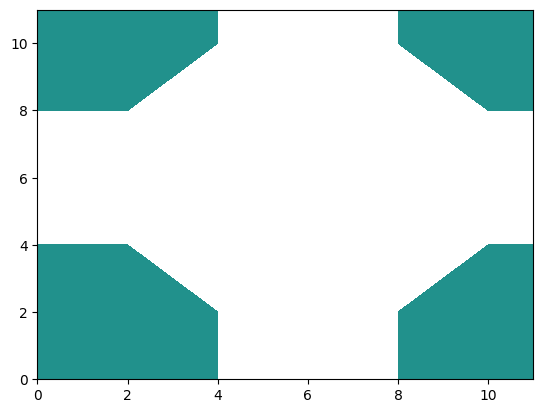

In [14]:
plt.contourf(corners())

In [15]:
def diag_mask(array):
    size = array.shape[0]
    return map2d(array, lambda _, i, j: (np.abs(i - j) > np.ceil(size/8.)))

def diag():
    size = 7
    z = np.zeros([size, size])
    a = np.where(diag_mask(z), np.random.rand(1), np.NAN)
    return(a)

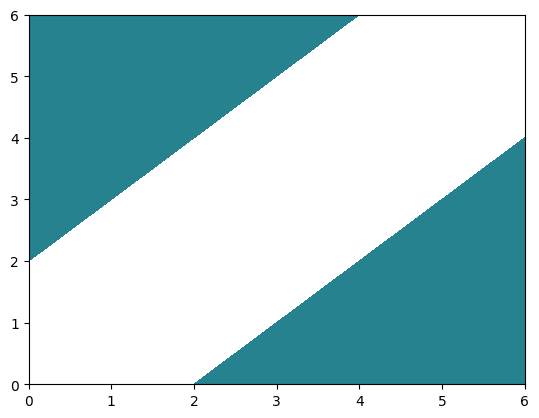

In [16]:
plt.contourf(diag())

## Array to Graph Conversion

Now we can implement functions to convert numpy-like arrays to networkx graphs. Since we are assuming the stencils we're interested in are two-dimensional grids, we can make some assumptions.

- We only need to add an edge for a node if its neighbor is above it or to the right. For a point in the middle of the stencil, the other two possible edges are already accounted for if we treat the stencil as a tesselation of individual nodes with two edges.
- For the stencil's upper and right-side boundaries, we don't need to check for upper and right-side edges, respectively. because there can't be another edge there.

The function `point_to_graph` likewise takes an individual point and returns valid edges between the point and its upward or rightward neighbor.

One some level, this method of drawing edges is arbitrary, so one could create different kinds of lattices by reworking this function.

In [17]:
def point_to_graph(mask, i, j, imax, jmax, weight=1.0):
    edges = []

    if not (j == jmax):
        if mask[i, j+1]:
            edges.append([(i,j), (i,j+1), weight])

    if not (i == imax):
        if mask[i+1,j]:
            edges.append([(i,j), (i+1,j), weight])

    return edges

Here we have the actual functions for constructing an individual graph. Considering that a graph's shape is independent of the data, we can also construct a "blank" graph from a NaN mask, so that's also provided here.

networkx graphs are constructed by initializing a graph with `nx.Graph`, then adding individual nodes and edges. Since we already worked out how to find edges iteratively, we can use the same pattern here. 

In [18]:
# def np_point_degree(array, i, j):
#     return np.sum(np.isnan([array([i,j+1]),
#                             array([i,j-1]),
#                             array([i+1,j]),
#                             array([i-1,j])]))

def np_array_to_graph(array):
    graph = nx.Graph()
    mask = ~np.isnan(array)

    imax = array.shape[0]-1
    jmax = array.shape[1]-1

    for i in range(0, imax+1):
        for j in range(0, jmax+1):
            if mask[i,j]:
                graph.add_node((i,j))
                edges = point_to_graph(mask, i, j, imax, jmax)
                graph.add_weighted_edges_from(edges)
            
    return graph

def np_mask_to_graph(mask):
    array = np.zeros(mask.shape)
    for i in range(0, array.shape[0]):
        for j in range(0,array.shape[1]):
            if not mask[i, j]:
                array[i, j] = np.nan
    return np_array_to_graph(array)

Now, we want to separate any graphs that contain independent subgraphs with `nx.connected_components`.

In [19]:
def np_array_to_subgraphs(array):
    g = np_array_to_graph(array)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

def np_mask_to_subgraphs(mask):
    g = np_mask_to_graph(mask)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

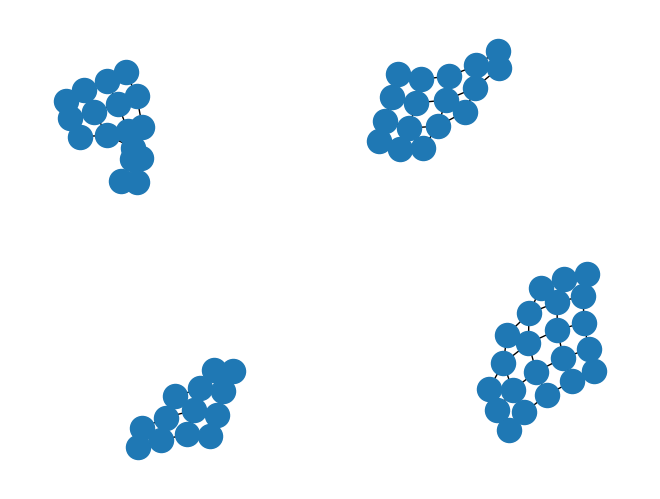

In [20]:
c = corners()
gc = np_array_to_graph(c)
nx.draw(gc)

We can see that even though the four distinct subgraphs from `corners()` are distorted, they have the same basic shape the did when we plotted the data as an array.

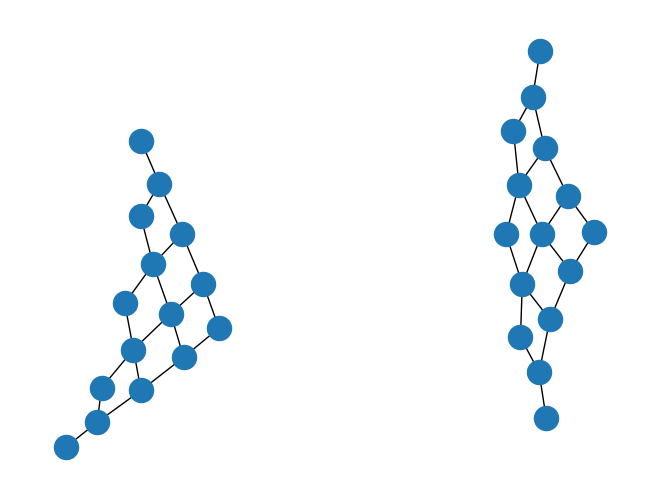

In [21]:
d = diag()
gd = np_array_to_graph(d)
nx.draw(gd)

The same is true when we plot graphs from `diag()`. These plots prove that we can successfully separate subgraphs, and therefore, we won't have to worry about this problem when we look at data near coastlines.

You can see the individual subgraphs in greater detail in the next code block.

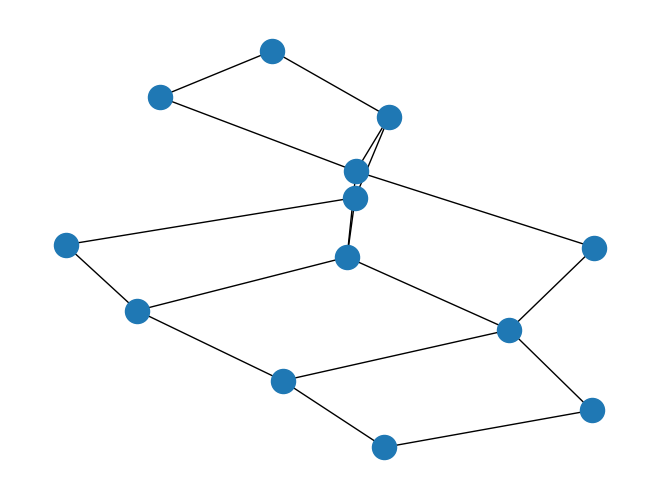

In [22]:
subgc = np_array_to_subgraphs(c)
subgd = np_array_to_subgraphs(d)
nx.draw(subgc[3])

Now we can generalize to xarray datasets.

In [23]:
# bgen = xb.BatchGenerator(
#     ds_training,
#     {'nlon':6, 'nlat':6},
#     {'nlon':2, 'nlat':2}
# )

In [24]:
# for batch in bgen:
#     a = batch
#     break
# a

In [25]:
# TEMP: formalize this

nlats = 5
nlons = 5
halo_size=1

In [26]:
latlen = len(ds_training['nlat'])
lonlen = len(ds_training['nlon'])
nlon_range = range(nlons,lonlen,nlons - 2*halo_size)
nlat_range = range(nlats,latlen,nlats - 2*halo_size)

batch = (
    ds_training
    .rolling({"nlat": nlats, "nlon": nlons})
    .construct({"nlat": "nlat_input", "nlon": "nlon_input"})[{'nlat':nlat_range, 'nlon':nlon_range}]
    .stack({"input_batch": ("nlat", "nlon")}, create_index=False)
    .rename_dims({'nlat_input':'nlat', 'nlon_input':'nlon'})
    .transpose('input_batch',...)
    # .chunk({'input_batch':32, 'nlat':nlats, 'nlon':nlons})
    .dropna('input_batch')
)

In [27]:
rnds = list(range(len(batch['input_batch'])))
np.random.shuffle(rnds)
batch = batch[{'input_batch':(rnds)}]

c:\Users\cdupu\anaconda3\envs\gnnCookbook\lib\site-packages\xarray\core\indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 3115 times more chunks
  return self.array[key]


In [28]:
len(batch['input_batch'])

20930

In [29]:
batch2 = batch[{'input_batch':0}]

In [30]:
def graph_builder(mask, vars, names):
    
    imax = mask.shape[0]-1
    jmax = mask.shape[1]-1

    vars_graph = nx.Graph()
    for i in range(0, imax+1):
        for j in range(0, jmax+1):
            if mask[i, j]:
                edges = point_to_graph(mask, i, j, imax, jmax)
                vars_ij = {x:vars[x][i,j] for x in names} #vars[x][i,j].to_numpy()
                vars_graph.add_node((i,j), **vars_ij)
                vars_graph.add_weighted_edges_from(edges,)
                
                # add self-loops
                # vars_graph.add_edge((i,j), (i,j), weight=1.)

    return vars_graph

In [31]:
def contract(vars, mask, halo):

    latmax = mask.sizes['nlat']
    lonmax = mask.sizes['nlon']
    
    latrange = range(halo, latmax-halo)
    lonrange = range(halo, lonmax-halo)
    
    stencil = {'nlat': latrange, 'nlon': lonrange}

    sub = vars[stencil]
    stencilled = {k:v.to_numpy() for k,v in sub.items()}
    return stencilled

In [32]:
def convolve(vars, mask, kernel):
    '''
    Assumes kernel is a NxN matrix where N is odd
    '''

    latmax = mask.sizes['nlat']
    lonmax = mask.sizes['nlon']

    halo_lat = int(np.floor(kernel.sizes['nlat'] / 2.))
    halo_lon = int(np.floor(kernel.sizes['nlon'] / 2.))
    
    latrange = range(halo_lat, latmax-halo_lat)
    lonrange = range(halo_lon, lonmax-halo_lon)

    conved = dict()
    for k, v in vars.items():

        cvar = np.zeros_like(v[latrange, lonrange])
        for i, j in product(latrange, lonrange):
            stencil = {"nlat": slice(i-halo_lat, i+halo_lat+1), "nlon": slice(j-halo_lon, j+halo_lon+1)}
            msub = mask[stencil]

            denominator = np.abs(kernel * msub).sum(dim=['nlat', 'nlon']) 
            if denominator == 0: # Should these be NaNs?
                continue
            
            vsub = v[stencil]
            numerator = (kernel * msub * vsub).sum(dim=['nlat', 'nlon'])
            if np.isclose(numerator, 0.): # check tolerance vs. variable values 
                cvar[i-halo_lat,j-halo_lon] = 0.
            else:
                cvar[i-halo_lat,j-halo_lon] = numerator / denominator

        conved.update({k:cvar})

    return conved

In [33]:
kernel = xr.DataArray([[0,  1, 0],
                       [-1, 0, 1],
                       [0, -1, 0]],
                       dims=["nlat", "nlon"])

In [34]:
mask = batch2['mask']

conv_f   = convolve(batch2[sc5.conv_var],  mask, kernel)

features = contract(batch2[sc5.input_var], mask, 1)
targets  = contract(batch2[sc5.target],    mask, 1)

In [35]:
mask = contract(batch2[['mask']], mask, 1) # silly, but it works

In [36]:
features = features | conv_f

In [37]:
def xr_ds_to_graph(batch, sc, kernel):

    mask = batch['mask']

    # convolve and contract here

    conv_f   = convolve(batch[sc5.conv_var],  mask, kernel)

    features = contract(batch[sc5.input_var], mask, 1)
    targets  = contract(batch[sc5.target],    mask, 1)
    mask     = contract(batch[['mask']],      mask, 1)['mask'] # silly, but it works
    
    features = features | conv_f

    features_graph = graph_builder(mask, features, sc.conv_var + sc.input_var)
    targets_graph  = graph_builder(mask, targets,  sc.target)

    return features_graph, targets_graph

As before, we want to ensure that separate subgraphs are treated individually.

In [38]:
def xr_ds_to_subgraphs(batch, sc, kernel):
    f, t = xr_ds_to_graph(batch, sc, kernel)
    fsub = [f.subgraph(sub) for sub in nx.connected_components(f)]
    tsub = [t.subgraph(sub) for sub in nx.connected_components(t)]
    return fsub, tsub

Need to convert arrays to subgraphs BEFORE the user-level batch generator, because we don't know how many subgraphs 'batch_to_subgraphs' is going to return.

In [39]:
'''
This function is just a placeholder function for various graph convolution operators, which can be passed to ggen_subgs.
'''

def graph_conv(graph):
    return nx.laplacian_matrix(graph) * graph

In [40]:
#gconv=graph_conv
fsub, tsub = xr_ds_to_subgraphs(batch2, sc5, kernel)
#fsub

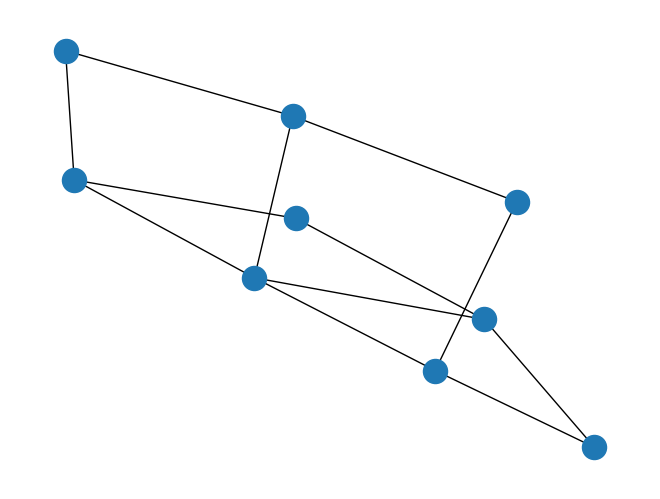

In [41]:
nx.draw(fsub[0])

In [42]:
from_networkx(fsub[0])

Data(edge_index=[2, 24], SSH=[9], SST=[9], X=[9], TAUX=[9], TAUY=[9], weight=[24], num_nodes=9)

In [43]:
from_networkx(fsub[0], group_node_attrs= sc5.conv_var + sc5.input_var)

Data(edge_index=[2, 24], weight=[24], x=[9, 5])

In [44]:
from_networkx(tsub[0], group_node_attrs=sc5.target)

Data(edge_index=[2, 24], weight=[24], x=[9, 2])

In [45]:
def ggen_subgs(batch_set, kernel, gconv=graph_conv):
    for i in range(len(batch_set['input_batch'])):
        batch = batch_set[{'input_batch':i}]
        fsub, tsub = xr_ds_to_subgraphs(batch, sc5, kernel)

        for j in range(len(fsub)):
            # something goes wrong with the data structure here; we want
            # graphs of tuples, not multiple graphs for each variable
            fpy = from_networkx(fsub[j], group_node_attrs = sc5.conv_var + sc5.input_var)
            tpy = from_networkx(tsub[j], group_node_attrs = sc5.target)
            yield (fpy, tpy)

In [46]:
asdfasdf = ggen_subgs(batch, kernel, gconv=convolve)
f, t = next(asdfasdf)

In [47]:
batchz = batch[{'input_batch':0}]
fsub, tsub = xr_ds_to_subgraphs(batchz, sc5, kernel)

In [48]:
fsub[0]

In [49]:
nx.laplacian_matrix(fsub[0]).todense() 

array([[ 2., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  3.,  0., -1., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  3.,  0., -1.,  0., -1.,  0.,  0.],
       [ 0., -1.,  0.,  2.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0.,  4., -1.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1., -1.,  3.,  0.,  0., -1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0., -1.,  3., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  2.]])

In [50]:
# something is slow in here
def batch_generator(bgen, batch_size):
    b = (batch for batch in bgen)
    n = 0
    feats = list()
    targs = list()
    while n < 400:
        batch = [     next(b) for i in range(batch_size) ]
        feats = [ batch[i][0] for i in range(batch_size) ]
        targs = [ batch[i][1] for i in range(batch_size) ]
        
        yield feats, targs
        n += 1

In [51]:
# bgen = batch_generator(batch, 4096)
bgen = batch_generator(ggen_subgs(batch, kernel), 32)

In [52]:
f, t = next(bgen)

In [53]:
f[0].weight


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])

In [54]:
type(f[0])

torch_geometric.data.data.Data

In [55]:
train_loader = torch_geometric.loader.DataLoader(f, batch_size=8, shuffle=True)

In [56]:
for a in train_loader:
    print(a.x)
    break

tensor([[ 3.9950e-01, -1.4616e-02, -2.4291e-01, -1.8647e+00,  3.7319e-01],
        [ 3.9741e-01, -9.1624e-03, -2.4291e-01, -1.8785e+00,  3.8573e-01],
        [ 3.9618e-01, -1.3974e-02, -2.4127e-01, -1.8767e+00,  3.9164e-01],
        [ 4.1889e-01, -2.4028e-03, -2.4291e-01, -1.8954e+00,  4.0097e-01],
        [ 4.0461e-01, -7.2465e-03, -2.4127e-01, -1.8910e+00,  4.0521e-01],
        [ 4.3423e-01, -4.3759e-03, -2.4127e-01, -1.9073e+00,  4.2101e-01],
        [ 3.9874e-01, -9.7928e-03, -2.3962e-01, -1.8892e+00,  4.1178e-01],
        [ 4.1374e-01, -3.6273e-03, -2.3962e-01, -1.9043e+00,  4.2640e-01],
        [ 4.4964e-01, -4.6358e-03, -2.3962e-01, -1.9202e+00,  4.4280e-01],
        [ 6.3320e-01,  5.7061e-02, -7.2512e-01,  6.8882e+00, -1.7006e+00],
        [ 9.5077e-01,  1.6614e-01, -7.2512e-01,  7.0879e+00, -1.7372e+00],
        [ 7.3530e-01,  1.1217e-01, -7.2430e-01,  6.8310e+00, -1.6783e+00],
        [ 1.0813e+00,  2.1980e-01, -7.2512e-01,  7.3167e+00, -1.7948e+00],
        [ 9.7525e-01,  1.

In [57]:
class MPD_in(MessagePassing):
    def __init__(self, in_channels, out_channels, message_channels):
        super().__init__(aggr='add')
        self.lin_1 = Linear(in_channels, out_channels)
        self.lin_2 = Linear(in_channels, out_channels)
        self.mlp = Seq(Linear(2 * in_channels + 2, message_channels),
                       ReLU(),
                       Linear(message_channels, in_channels))
        
    def forward(self, x, edge_index, edge_attr): #edge_attr
        out = self.propagate(x=x, edge_index=edge_index, edge_attr=edge_attr) #edge_attr=edge_attr
        out += self.lin_1(x) # Using += here is like a skip-connection, as opposed to = (according to Alex)
        return out

    def message(self, x_i, x_j, edge_attr): # edge_attr
        tmp = torch.cat([x_i,x_j],1) #edge_attr
        return self.lin_2(self.mlp(tmp)*(x_i-x_j))

In [58]:
# from inspect import signature
# mlp = Seq(Linear(2 * 1 + 2, 200),
#           ReLU(),
#           Linear(200, 1))
# mlp

In [59]:
class MsgModelDiff(torch.nn.Module):

    def __init__(self, num_in = 1, num_out = 2, num_hidden = 30, num_message = 200):
        super().__init__()
        self.layer_diff = MPD_in(num_in,num_hidden,num_message)
        self.layer_h = MPD_in(num_hidden,num_hidden,num_message)
        self.layer_out = MPD_in(num_hidden,num_out,num_message)
        self.relu = torch.nn.ReLU()

    def forward(self, features, edges, weights):
        x = self.layer_diff(features, edges, weights)
        x = self.relu(x)
        x = self.layer_h(x, edges, weights)
        x = self.relu(x)
        x = self.layer_h(x, edges, weights)
        x = self.relu(x)
        x = self.layer_h(x, edges, weights)
        x = self.relu(x)
        x = self.layer_out(x, edges, weights)
        return x

In [60]:
def train(model, num_epochs=1):
    # Set up the loss and the optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(num_epochs):
        # for f, t in bgen:

        #     for i in range(len(f)):

        #         # feat_loader = torch_geometric.loader.DataLoader(f, batch_size=8, shuffle=False)
        #         # targ_loader = torch_geometric.loader.DataLoader(t, batch_size=8, shuffle=False)

        #         optimizer.zero_grad()
        #         outs = model(f[i], loader.edge_index, loader.weight)
        #         loss = loss_fn(outs, t[i])
        #         loss.backward()
        #         optimizer.step()

        #for data in loader: # probably obsolete
        
        for f, t in batch_generator(ggen_subgs(batch, kernel), 32):
            for features, targets in zip(f, t):
            
                # weights = [[x] for x in features.weight]
                # print(weights)

                optimizer.zero_grad()
                outs = model(features.x, features.edge_index, features.weight)
                loss = loss_fn(outs, targets.x)
                loss.backward()
                optimizer.step()

        if epoch%5==0:    
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss}')

In [61]:
model = MsgModelDiff(num_in = 2,num_hidden=40,num_message=100)

In [62]:
#train(model)

In [96]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

for features, targets in zip(f, t):

    optimizer.zero_grad()
    outs = model(features.x, features.edge_index, features.weight)
    loss = loss_fn(outs, targets.x)
    loss.backward()
    optimizer.step()

RuntimeError: mat1 and mat2 must have the same dtype